<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Natural Language Processing - Classifying Definitions of Nouns and Adjectives

---
## Part 3: Modelling, Insights & Applications
---

## Contents
---
- [Overview-of-Models](##Overview-of-Models)
- [Baseline Models](##Baseline-Models)
- [Modelling](##Modelling)
- [Final Selection of Models](##Final-Selection-of-Models)
- [Explanatory Data Analysis](##Explanatory-Data-Analysis)
- [Applications, Limitations & Further Extensions](##Applications,-Limitations-&-Further-Extensions)

---
## Overview
---

A total of 4 different classification models will be used: Naive Bayes (NB), Logistic Regression (LR), Random Forest (RF) and K-Nearest Neighbours (KNN).

### Naive Bayes (NB)

Naive Bayes is a probabilistic model that assigns probabilities to features based on the model’s assessment of each feature’s individual impact on classification. A key assumption made by the model is that of independence of features. This could give rise to issues, especially when some features are highly correlated with one another. However, how much it negatively impacts accuracy depends on the nature of the data itself. For example, correlated features that are poor indicators of either class may not have a large overall impact, whereas correlated features that are strong indicators of either class may have a significant impact when they appear together.

In the context of this NLP project, formal definitions tend to be structured and more rigorously vetted. Such instances of multicollinearity are likely to be lower. Moreover, if they do exist and are strong indicators of either class, it would have been flagged out during the EDA stage. There is one such pair - ‘act’ and ‘instance’. However, they are such strong indicators of nouns that they exist almost entirely within definitions of nouns. Therefore, the actual impact of their coexistence is unlikely to be large.

Based on the above, it is possible to see why NB often performs reasonably well despite this assumption. In addition, being a simple and straightforward model, it is computationally efficient and very easy to interpret, which makes it a rather popular model for relatively straightforward NLP tasks such as this.

### Logistic Regression (LR)

Logistic Regression is a regression model that analyses and models the relationship between predictor variables and outcome variables (binary in this case). Unlike NB, it does not assume independence of features. Instead, it is able to learn the relationships between features to a certain extent, and reflect its ‘findings’ in a linear equation where each feature is assigned a coefficient. Specifically, the model is trained using maximum likelihood estimation, whereby it seeks to find the set of model parameters that maximise the likelihood of the observed data. 

Its main assumption is that of linearity, which could be an issue when the input data is more complex. For example, the relationships between features may not be linear when the tone of the text matters (sarcasm, etc.) Therefore, in the context of this NLP project, it is unlikely that this assumption is erroneous, or at least not to any noticeable extent. 

LR, like NB, is computationally efficient and interpretable, which makes it an equally popular classification model.

### Random Forest (RF)

Random Forest is an ensemble model that consists of many different Decision Trees (DTs). Each tree is trained on a random subset of the data and features. DTs themselves work similarly to flowcharts. At each node, the optimal split is made - this means that the model chooses the feature that would result in the greatest reduction of ‘uncertainty’. It does this using a metric such as the Gini impurity. As such, features that are higher up in the tree tend to viewed as more important since they are more ‘influential’, ie. their presence is more critical to the outcome

When making a classification, RF takes into account all of its trees, ie. it goes with the majority vote. The ensemble nature of the RF makes it less prone to overfitting than individual DTs. 

Unlike NB and LR, RF is more suited to tackling more complicated classification tasks such as when nonlinear relationships exist. However, in part due to its ensemble nature, it is more computationally expensive as compared to NB and LR.

### K-Nearest Neighbours (KNN)

K-Nearest Neighbours is a nonparametric model that relies on the concept of distance to make predictions. For each data point and a specified number of neighbours, k, the model looks for the k neighbours closest to the data point. It then classifies the data point according to the class that a majority of the neighbours are in. The distance metric used to measure the similarity points differs, but Euclidean distance and Manhattan distance are both popular choices.

An advantage of KNN is that it may be less affected by ‘noise’ or irrelevant data, although not completely unaffected. However, it can be computationally expensive, especially when the number of features is high, because of the distance computations.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Function that vectorises input data and models it.

def vectorise_and_model(df=None,
                        use_spacy=True,
                        vectoriser='cvec',
                        min_df=1, 
                        max_df=1.0, 
                        ngram_range=(1,2),
                        max_features=None,
                        stop_words=None,
                        model_type=None,
                        nb_alpha=1.0,
                        lr_C=1.0,
                        rf_max_depth=None,
                        rf_min_samples_split=2,
                        knn_n_neighbours=5):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    use_spacy : bool
        If True, POS will be included in the modelling process.
    min_df : int, float
        Minimum number (int) or percentage (float) of occurences, 
        across observations, needed for word (feature) to be included.
    max_df : int, float
        Upper limit (number, if int; percentage, if float) of occurences, 
        across observations, beyond which a word (feature) will not be included.
    ngram_range : tuple
        Minimum and maximum ngrams to use during the vectorisation process.
    max_features : int
        Maximum number of features to include in model.
    stop_words : list of str
        List of words to exclude when applying vectorisation.
    model_type : str
        Accepts 'nb', 'lr', 'rf', 'knn'.
    nb_alpha : float
        Smoothing parameter to be used for MultinomialNB().
    lr_C : float
        Regularisation strength to be used for LinearRegression().
    rf_max_depth : int
        Maximum depth of each tree to be used for RandomForestClassifier().
    rf_min_samples_split : int
        Minimum number samples required before a split can be formed.
        Used for RandomForestClassifier().
    knn_n_neighbours : int
        Number of neighbours to be used for KNeighborsClassifier().
    '''
    
    # Column to be used depends on whether or not parts-of-speech (POS) are included.
    if use_spacy:
    
        X = df['definitions_and_pos']
        
    else:
        
        X = df['definition']
    
    y = df['word_class']

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
        
    if vectoriser == 'cvec':

        vec = CountVectorizer(stop_words=stop_words,
                              min_df=min_df, 
                              max_df=max_df,
                              ngram_range=ngram_range,
                              max_features=max_features)
        
    elif vectoriser == 'tvec':
        
        vec = TfidfVectorizer(stop_words=stop_words,
                              min_df=min_df,
                              max_df=max_df,
                              ngram_range=ngram_range,
                              max_features=max_features)
        
    vec.fit(X_train)
    
    X_train = vec.transform(X_train)
    
    X_test = vec.transform(X_test)
    
    # Obtain feature names.
    feature_names = vec.get_feature_names_out()

    # DataFrame where each column represents a feature and...
    # values within the DataFrame represent their numerical counts.
    # Only for training data.
    X_train_df = pd.DataFrame(X_train.todense(), 
                              columns=vec.get_feature_names_out())

    # Same as above, but for test data.
    X_test_df = pd.DataFrame(X_test.todense(), 
                             columns=vec.get_feature_names_out())

    # Create a DataFrame that reflects, for the training data, the:
    # 1) actual word classes, and
    # 2) sparse matrix of the vectorised X_train.
    df_train_processed = pd.merge(pd.DataFrame(y_train).reset_index(), 
                                  X_train_df, 
                                  how='outer', 
                                  left_index=True, 
                                  right_index=True)

    # Same as the above, but for test data.
    df_test_processed = pd.merge(pd.DataFrame(y_test).reset_index(), 
                                 X_test_df, 
                                 how='outer', 
                                 left_index=True, 
                                 right_index=True)

    # Merge the above DataFrames.
    df_processed = pd.concat([df_train_processed, df_test_processed]).reset_index().drop('level_0', 
                                                                                         axis=1, 
                                                                                         errors='ignore')
    
    # There are 4 possible choices of models.
    if model_type == 'nb':
    
        model = MultinomialNB(alpha=nb_alpha)
        
    elif model_type == 'lr':
        
        model = LogisticRegression(C=lr_C, 
                                   max_iter=200)
        
    elif model_type == 'rf':
        
        model = RandomForestClassifier(max_depth=rf_max_depth,
                                       min_samples_split=rf_min_samples_split,
                                       random_state=42)
        
    elif model_type == 'knn':
        
        model = KNeighborsClassifier(n_neighbors=knn_n_neighbours)

    model.fit(X_train, y_train)
    
    # Generate predictions for both training and data sets.
    preds_train, preds_test = model.predict(X_train), model.predict(X_test)

    # Obtain cross-validation score.
    cv = cross_val_score(model, X_train, y_train)
    
    # Obtain accuracy scores for both training and test data.
    accuracy_train, accuracy_test = model.score(X_train, y_train), model.score(X_test, y_test)

    # Obtain true negative, false positive, false negative and true positive scores.
    tn, fp, fn, tp = confusion_matrix(y_test, preds_test).ravel()

    # Obtain specificity score.
    specificity = tn/(tn+fp)
    
    # Obtain the recall, precision and f1 scores.
    recall, precision, f1 = [fn(y_test, preds_test) for fn in [recall_score, precision_score, f1_score]]
    
    # Create a DataFrame that shows the hyperparameters that were used by the vectoriser and model.
    df_params = pd.DataFrame.from_dict({'model': model_type,
                                        'vectoriser' : vectoriser,
                                        'min_df': min_df,
                                        'max_df': max_df,
                                        'ngram': ngram_range,
                                        'n_features': X_train_df.shape[1],
                                        'nb_alpha': nb_alpha,
                                        'lr_C': lr_C,
                                        'rf_max_depth': rf_max_depth,
                                        'rf_min_samples_split': rf_min_samples_split,
                                        'knn_n_neighbours': knn_n_neighbours},
                                       orient='index').transpose()
    
    # Create a dictionary that shows the scores calculated above.
    scores = {col_name: np.round(score, 2) \
              for col_name, score in \
              zip(['cv_mean', 'accuracy_train', 'accuracy_test', 'specificity', 'recall', 'precision', 'f1'], 
                  [np.mean(cv), accuracy_train, accuracy_test, specificity, recall, precision, f1])}
    
    # Manually include the list of 5 cv scores in the abovementioned dictionary.
    scores['cv'] = [np.round(score, 2) for score in cv]
    
    # Create a DataFrame based on the scores dictionary.
    df_scores = pd.DataFrame.from_dict(scores, orient='index').transpose()
    
    # Merge the scores and params DataFrame to maximise information shown.
    # Specifically useful for figuring out the best set of hyperparameters to use after generating multiple models.
    df_params_scores = pd.concat([df_params, df_scores], axis=1)
    
    # Return a dictionary that takes into consideration anything that might be needed after the modelling stage.
    info = {
        'model': model,
        'vec': vec,
        'X_train': X_train, 
        'y_train': y_train, 
        'X_test': X_test, 
        'y_test': y_test, 
        'preds_train': preds_train,
        'preds_test': preds_test,
        'X_train_df': X_train_df, 
        'X_test_df': X_test_df,
        'feature_names': feature_names,
        'df_train_processed': df_train_processed,
        'df_test_processed': df_test_processed,
        'df_processed': df_processed,
        'df_params_scores': df_params_scores
    }

    return info

In [3]:
# Function to 'brute force' modelling to generate the best set of hyperparameters.

def finetune_models(df=None,
                    vectorisers=['cvec'],
                    use_spacy=True,
                    min_df_range=[10, 15, 20, 25, 30],
                    max_df_range=np.linspace(0.5, 0.7, 5),
                    ngram_ranges=[(1,2)],
                    stop_words=None,
                    model_type=None,
                    nb_alpha_range=[1.0],
                    lr_C_range=[1.0],
                    rf_use_max_depth=True,
                    rf_max_depth_range=None,
                    rf_min_samples_split_range=[2],
                    knn_n_neighbours_range=[5]):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    vectorisers : list of str
        Accepts 'cvec' and 'tvec' for list elements. Indicates vectorisers to be used.
    use_spacy : bool
        If True, POS will be included in the modelling process.
    min_df_range : list of int or float
        Each element represets the minimum number (int) or percentage (float) of occurences, 
        across observations, needed for word (feature) to be included.
    max_df_range : list of int of float
        Each element represets the upper limit (number, if int; percentage, if float) of occurences, 
        across observations, beyond which a word (feature) will not be included.
    ngram_ranges : list of tuples
        Each element represets the minimum and maximum ngrams to use during the vectorisation process.
    stop_words : list of str
        List of words to exclude when applying vectorisation.
    model_type : str
        Accepts 'nb', 'lr', 'rf', 'knn'.
    nb_alpha_range : list of float
        Each element represets the smoothing parameter to be used for MultinomialNB().
    lr_C_range : list of float
        Each element represets the regularisation strength to be used for LinearRegression().
    rf_use_max_depth : bool
        If True, model will loop through the rf_max_depth_range hyperparamter.
    rf_max_depth_range : list of int
        Each element represets the maximum depth of each tree to be used for RandomForestClassifier().
    rf_min_samples_split_range : list of int
        Each element represets the minimum number samples required before a split can be formed.
        Used for RandomForestClassifier().
    knn_n_neighbours_range : list of int
        Each element represets the number of neighbours to be used for KNeighborsClassifier().
    '''
    
    # Create an empty DataFrame.
    # Will be merged with each model's df_params_score DataFrame.
    df_all = pd.DataFrame()
    
    # Hyperparameters for vectorisers are common to all models and...
    # ...will be looped through regardless of model type chosen.
    # Model-specific hyperparameters will be looped through depending on the choice of model.
    for vectoriser in vectorisers:

        for min_df in min_df_range:

            for max_df in max_df_range:
                
                for ngram_range in ngram_ranges:

                    if model_type == 'nb':

                        for alpha in nb_alpha_range:

                            df_params_scores = vectorise_and_model(df=df, 
                                                                   use_spacy=use_spacy,
                                                                   vectoriser=vectoriser,
                                                                   model_type=model_type,
                                                                   min_df=min_df,
                                                                   max_df=max_df,
                                                                   ngram_range=ngram_range,
                                                                   stop_words=stop_words,
                                                                   nb_alpha=alpha)['df_params_scores']

                            df_all = pd.concat([df_all, df_params_scores])

                    elif model_type == 'lr':

                        for C in lr_C_range:

                            df_params_scores = vectorise_and_model(df=df, 
                                                                   use_spacy=use_spacy,
                                                                   vectoriser=vectoriser,
                                                                   model_type=model_type,
                                                                   min_df=min_df,
                                                                   max_df=max_df,
                                                                   ngram_range=ngram_range,
                                                                   stop_words=stop_words,
                                                                   lr_C=C)['df_params_scores']

                            df_all = pd.concat([df_all, df_params_scores])

                    elif model_type == 'rf':

                        # The rf_max_depth_range hyperparameter is unique in that...
                        # ...it reflects a maximum and can't be None...
                        # ...therefore, an if statement must be included for it.
                        if rf_use_max_depth:

                            for max_depth in rf_max_depth_range:
                                
                                for min_samples_split in rf_min_samples_split_range:

                                    df_params_scores = vectorise_and_model(
                                        df=df, 
                                        use_spacy=use_spacy,
                                        vectoriser=vectoriser,
                                        model_type=model_type,
                                        min_df=min_df,
                                        max_df=max_df,
                                        ngram_range=ngram_range,
                                        stop_words=stop_words,
                                        rf_max_depth=max_depth,
                                        rf_min_samples_split=min_samples_split)['df_params_scores']

                                    df_all = pd.concat([df_all, df_params_scores])
                                
                        else:
                            
                            for min_samples_split in rf_min_samples_split_range:
                                    
                                df_params_scores = vectorise_and_model(df=df, 
                                                                       use_spacy=use_spacy,
                                                                       vectoriser=vectoriser,
                                                                       model_type=model_type,
                                                                       min_df=min_df,
                                                                       max_df=max_df,
                                                                       ngram_range=ngram_range,
                                                                       stop_words=stop_words,
                                                                       rf_min_samples_split=min_samples_split)['df_params_scores']

                                df_all = pd.concat([df_all, df_params_scores])

                    elif model_type == 'knn':

                        for n_neighbours in knn_n_neighbours_range:

                            df_params_scores = vectorise_and_model(df=df, 
                                                                   use_spacy=use_spacy,
                                                                   vectoriser=vectoriser,
                                                                   model_type=model_type,
                                                                   min_df=min_df,
                                                                   max_df=max_df,
                                                                   ngram_range=ngram_range,
                                                                   stop_words=stop_words,
                                                                   knn_n_neighbours=n_neighbours)['df_params_scores']

                            df_all = pd.concat([df_all, df_params_scores])

        
    return df_all

In [4]:
# Function to filter models.
# Created to avoid having overly-long lines of code.

def filter_models(models=None,
                  model_type=None,
                  accuracy_train_min=0.9,
                  accuracy_test_min=0.9,
                  accuracy_diff_max=0.03,
                  recall_min=0.89,
                  specificity_min=0.89,
                  f1_min=0.89,
                  n_features_max=1000,
                  sort_by='recall',
                  ascending=False):
    
    '''   
    Parameters
    ----------
    models : pd.DataFrame
        DataFrame to be used in function.
    model_type : str
        Accepts 'nb', 'lr', 'rf', 'knn'.
    accuracy_train_min : float
        Filter criteria for `accuracy_train` col.
    accuracy_test_min : float
        Filter criteria for `accuracy_test` col.
    accuracy_diff_max : float
        Filter criteria; manages difference between
        `accuracy_train` & `accuracy_test`.
    recall_min : float
        Filter criteria for `recall` col.
    specificity_min : float
        Filter criteria for `specificity` col.
    f1_min : float
        Filter criteria for `f1` col.
    n_features_max : int
        Filter criteria for `n_features` col.
    sort_by : str
        Specifies which column to sort DataFrame by.
    ascending : bool
        Specifies whether or not to sort in ascending or descending order.
    '''

    # List of all columns that are model-specific.
    cols_to_drop = ['nb_alpha', 
                    'lr_C', 
                    'rf_max_depth', 
                    'rf_min_samples_split',
                    'knn_n_neighbours'] 
    
    # Removal of columns depends on type of model.
    if model_type == 'nb':
        
        cols_to_drop.remove('nb_alpha')
        
    elif model_type == 'lr':
        
        cols_to_drop.remove('lr_C')        
        
    elif model_type == 'rf':
        
        cols_to_drop.remove('rf_min_samples_split')
        
        # Due to how the modelling process is done, it's possible that this column does not exist.
        try:
            cols_to_drop.remove('rf_max_depth')
        except:
            pass
        
    elif model_type == 'knn':
        
        cols_to_drop.remove('knn_n_neighbours')
    
    display(models[
        (models.accuracy_train >= accuracy_train_min) & \
        (models.accuracy_test >= accuracy_test_min) & \
        ((models.accuracy_train - models.accuracy_test) <= accuracy_diff_max) & \
        (models.recall >= recall_min) & \
        (models.specificity >= specificity_min) & \
        (models.f1 >= f1_min) & \
        (models.n_features <= n_features_max)].sort_values(sort_by, ascending=ascending).drop(cols_to_drop, axis=1))

In [5]:
# Function to extract and return indexes of misclassified observations.

def extract_misclassed(df=None, model=None):    
    
    
    
    # Create an empty list to store the indexes.
    misclassed = []

    # Obtain predictions for training data.
    for index, actual, pred in zip(model['y_train'].index, model['y_train'].values, model['preds_train']):

        # Extract indexes of observations that were misclassified.
        if actual != pred:

            misclassed.append(index)

    # Obtain predictions for test data.
    for index, actual, pred in zip(model['y_test'].index, model['y_test'].values, model['preds_test']):

        # Extract indexes of observations that were misclassified.
        if actual != pred:

            misclassed.append(index)
    
    # Filter the main DataFrame by the indexes obtained above such that only the misclassified observations are left.
    df_misclassed = df.loc[misclassed, :]

    return df_misclassed

In [6]:
# Create a function to extract the probabilities of specific features in predicing nouns and adjectives.
# Aside from probabilities, returns a bunch of information to enable further analysis.

def probs(model=None):
    
    '''   
    Parameters
    ----------
    model : object
        Accepts an object that pertains to a fitted model.
    '''
    
    # Create an empty DataFrame that has the same shape and features as...
    # ...the vectorised X_train.
    df_id = pd.DataFrame(np.identity(model['X_train_df'].shape[1]), 
                         columns=[model['X_train_df'].columns])
    
    # Create a dictionary to store, for each feature, the probability of...
    # its presence indicating that the observation is a noun or an adjective.
    probs = {word: prob for word, prob in \
             zip(model['X_train_df'], 
                 np.round(model['model'].predict_proba(df_id), 5).tolist())}

    # Extract the df_processed DataFrame from the model. Recall that this reflects:
    # 1) actual word classes, and
    # 2) sparse matrix of the vectorised X_train.
    df_processed = model['df_processed']
    
    # For each feature:
    for word in probs.keys():

        # Separate df_processed by word class, and only extract those that are nonzero.
        df_noun = df_processed[(df_processed[word] > 0) & (df_processed.word_class == 0)]
        df_adj = df_processed[(df_processed[word] > 0) & (df_processed.word_class == 1)]

        # Obtain list of indexes of all predicted nouns.
        indexes_tn_fp = df_noun['index']

        # Obtain list of indexes of all predicted adjectives.
        indexes_tp_fn = df_adj['index']

        # Obtain list indexes of all misclassifications.
        indexes_fn_fp = extract_misclassed(df=df_words, model=model).index

        # Based on the above lists, extract relevant features:
        # 1) correctly-classified nouns;
        indexes_tn = [i for i in indexes_tn_fp if i not in indexes_fn_fp]

        # 2) nouns that were misclassified as adjectives;
        indexes_fp = [i for i in indexes_tn_fp if i not in indexes_tn]

        # 3) correctly-classified adjectives;
        indexes_tp = [i for i in indexes_tp_fn if i not in indexes_fn_fp]

        # 4) adjectives that were misclassified as nouns.
        indexes_fn = [i for i in indexes_tp_fn if i not in indexes_tp]
        
        # Obtain numbers of the above using the length of their lists.
        tn, fp, tp, fn = len(indexes_tn), len(indexes_fp), len(indexes_tp), len(indexes_fn)

        # Include number of occurrences (nouns) in dictionary.
        probs[word].append(df_noun.shape[0])
        
        # Include number of occurrences (adj) in dictionary.
        probs[word].append(df_adj.shape[0])

        # Include proportion of nouns (of all occurrences) in dictionary.
        probs[word].append(np.round(probs[word][2]/(probs[word][2]+probs[word][3]), 2))
        
        # For each of [tp, fp, tp, fn], include in the dictionary:
        # 1) indexes for the classification...
        # ...for example, indexes of definitions that were correctly classified as nouns)
        # 2) number of occurrences.
        for indexes, num in zip([indexes_tn, indexes_fp, indexes_tp, indexes_fn], [tn, fp, tp, fn]):
            
            probs[word].append(indexes)
            
            probs[word].append(num)
        
        # Due to potential division by 0, there is a need to utilise try-except blocks.
        # np.nan will be used as a filler if an error occurs.
        try:
            accuracy = (tn+tp)/(tn+fp+fn+tp)
        except:
            accuracy = np.nan

        try:
            spec = tn/(tn+fp)
        except:
            spec = np.nan

        try:
            recall = tp/(tp+fn)
        except:
            recall = np.nan

        try:
            precision = tp/(tp+fp)
        except:
            precision = np.nan
            
        try:
            f1 = 2 * (precision*recall)/(precision+recall)
        except:
            f1 = np.nan
        
        # Include the above metrics in the dictionary.
        # Do note that this means that the metrics are specific to the feature.
        for score in [accuracy, spec, recall, precision, f1]:
            
            probs[word].append(np.round(score, 2))

    # Create a DataFrame based on the probs dictionary.
    df = pd.DataFrame.from_dict(probs, 
                                orient='index', 
                                columns=[
                                    'prob_noun', 
                                    'prob_adj', 
                                    'count_noun', 
                                    'count_adj',
                                    'proportion_noun',
                                    'index_tn',
                                    'n_tn',
                                    'index_fp',
                                    'n_fp',
                                    'index_tp',
                                    'n_tp',
                                    'index_fn',
                                    'n_fn',
                                    'accuracy',
                                    'spec',
                                    'recall', 
                                    'precision',
                                    'f1'
                                ])
    
    df.reset_index(inplace=True)
    
    df.rename({'index': 'word'}, axis=1, inplace=True)
    
    return df

In [7]:
# Function to plot a bar chart to reflect feature importance.
# For NB, this refers to probability.
# For LR, this refers to coefficients.

def bar_eda(df=None, 
            xaxis=None, 
            col=None, 
            xlim=None, 
            add_line=True, 
            title=None, 
            xlabel=None, 
            ylabel=None, 
            rotation=90):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    xaxis : list of str
        List where elements should reflect relevant indexes.
    col : str
        Column of DataFrame to extract data from.
    xlim : float
        Value is used as a critera to determine colouring of bars.
    add_line : bool
        If True, a horizontal line will be included at y=0.
    title : str
        Title of chart.
    xlabel : str
        X-axis label.
    ylabel : str
        Y-axis label.
    rotation : int
        Degree of rotation of X-axis labels.
    '''
    
    # Create a figure and set of subplots.
    fig, ax = plt.subplots(figsize=(12,6))

    # Sets colours of bars based on a specific value.
    # Colours are used to differentiate between predictors of nouns vs those of adjectives.
    colours = ['coral' if x <= xlim else 'deepskyblue' for x in df[col]]
    
    # Create bar chart.
    ax.bar(xaxis, df[col], color=colours)

    # For charts that will include negative values, include this to include a horizontal line at y=0.
    if add_line:
        
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

    ax.set_title(f'Feature Importance ({title})')
    ax.set_xlabel('Features')
    ax.set_ylabel(ylabel)

    # Rotate X-axis labels.
    plt.xticks(rotation=rotation)

    plt.show();

In [8]:
# Read in scraped data that includes parts of speech (POS).

df_words = pd.read_csv('../data/nouns_and_adjectives_and_pos.csv')

In [9]:
# Drop the unnecessary column.

df_words.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')

In [10]:
# Drop null values, if any.

df_words.dropna(inplace=True)

In [11]:
# Drop duplicates, if any.

df_words.drop_duplicates(inplace=True)

In [12]:
# Check that classes are reasonably balanced.

df_words.word_class.value_counts(normalize=True)

0    0.515712
1    0.484288
Name: word_class, dtype: float64

---
## Baseline Models
---

### CountVectorizer vs TfidfVectorizer

The baseline models will use the original dataset and default hyperparameters. Both CountVectorizer and TfidfVectorizer will be applied to the models to ascertain whether the former is always the better choice. The `ngram_range` hyperparameter will be tuned to show differences in performances by vectoriser across different combinations of data.

In [13]:
# Create a series of baseline NB models.

baseline_nb = finetune_models(df=df_words,
                              vectorisers=['cvec', 'tvec'], 
                              min_df_range=[1], 
                              max_df_range=[1.0], 
                              ngram_ranges=[(1,1), (1,2), (1,3), (2,2), (2,3)], 
                              model_type='nb')

In [14]:
# Display information on baseline NB models after filtering DataFrame for easy viewing.

baseline_nb.drop([col for col in baseline_nb.columns \
                  if col.startswith('lr') or col.startswith('rf') or col.startswith('knn')], 
                 axis=1)

,model,vectoriser,min_df,max_df,ngram,n_features,nb_alpha,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,nb,cvec,1,1.0,"(1, 1)",8220,1.0,0.85,0.95,0.84,0.92,0.76,0.9,0.83,"[0.86, 0.87, 0.83, 0.86, 0.84]"
0,nb,cvec,1,1.0,"(1, 2)",38161,1.0,0.89,0.99,0.88,0.97,0.78,0.96,0.86,"[0.91, 0.89, 0.88, 0.9, 0.88]"
0,nb,cvec,1,1.0,"(1, 3)",77433,1.0,0.9,1.0,0.88,0.98,0.78,0.97,0.86,"[0.9, 0.9, 0.88, 0.92, 0.88]"
0,nb,cvec,1,1.0,"(2, 2)",29941,1.0,0.89,0.99,0.88,0.98,0.77,0.97,0.86,"[0.88, 0.89, 0.89, 0.92, 0.87]"
0,nb,cvec,1,1.0,"(2, 3)",69213,1.0,0.89,1.0,0.88,0.97,0.78,0.97,0.87,"[0.89, 0.9, 0.89, 0.91, 0.88]"
0,nb,tvec,1,1.0,"(1, 1)",8220,1.0,0.81,0.94,0.81,0.96,0.66,0.93,0.77,"[0.82, 0.81, 0.79, 0.82, 0.79]"
0,nb,tvec,1,1.0,"(1, 2)",38161,1.0,0.85,0.98,0.86,0.99,0.73,0.98,0.84,"[0.87, 0.85, 0.84, 0.84, 0.84]"
0,nb,tvec,1,1.0,"(1, 3)",77433,1.0,0.87,0.98,0.87,0.99,0.75,0.98,0.85,"[0.88, 0.86, 0.85, 0.87, 0.86]"
0,nb,tvec,1,1.0,"(2, 2)",29941,1.0,0.87,0.99,0.88,0.98,0.78,0.97,0.87,"[0.88, 0.87, 0.86, 0.89, 0.85]"
0,nb,tvec,1,1.0,"(2, 3)",69213,1.0,0.88,0.98,0.88,0.97,0.79,0.96,0.87,"[0.9, 0.89, 0.87, 0.88, 0.86]"


In [15]:
# Create a series of baseline LR models.

baseline_lr = finetune_models(df=df_words,
                              vectorisers=['cvec', 'tvec'], 
                              min_df_range=[1], 
                              max_df_range=[1.0], 
                              ngram_ranges=[(1,1), (1,2), (1,3), (2,2), (2,3)], 
                              model_type='lr')

In [16]:
# Display information on baseline LR models after filtering DataFrame for easy viewing.

baseline_lr.drop([col for col in baseline_lr.columns \
                  if col.startswith('nb') or col.startswith('rf') or col.startswith('knn')], 
                 axis=1)

,model,vectoriser,min_df,max_df,ngram,n_features,lr_C,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,lr,cvec,1,1.0,"(1, 1)",8220,1.0,0.89,0.99,0.89,0.9,0.89,0.89,0.89,"[0.88, 0.9, 0.88, 0.9, 0.88]"
0,lr,cvec,1,1.0,"(1, 2)",38161,1.0,0.96,1.0,0.95,0.95,0.95,0.95,0.95,"[0.95, 0.95, 0.96, 0.97, 0.95]"
0,lr,cvec,1,1.0,"(1, 3)",77433,1.0,0.95,1.0,0.95,0.95,0.95,0.95,0.95,"[0.95, 0.95, 0.95, 0.97, 0.94]"
0,lr,cvec,1,1.0,"(2, 2)",29941,1.0,0.94,1.0,0.95,0.94,0.95,0.94,0.94,"[0.93, 0.95, 0.95, 0.95, 0.93]"
0,lr,cvec,1,1.0,"(2, 3)",69213,1.0,0.94,1.0,0.95,0.94,0.95,0.94,0.95,"[0.94, 0.95, 0.94, 0.95, 0.92]"
0,lr,tvec,1,1.0,"(1, 1)",8220,1.0,0.88,0.93,0.87,0.91,0.83,0.9,0.86,"[0.88, 0.89, 0.88, 0.89, 0.85]"
0,lr,tvec,1,1.0,"(1, 2)",38161,1.0,0.9,0.96,0.89,0.94,0.83,0.93,0.88,"[0.89, 0.91, 0.89, 0.91, 0.88]"
0,lr,tvec,1,1.0,"(1, 3)",77433,1.0,0.9,0.96,0.89,0.95,0.83,0.94,0.88,"[0.9, 0.92, 0.88, 0.91, 0.88]"
0,lr,tvec,1,1.0,"(2, 2)",29941,1.0,0.89,0.96,0.89,0.94,0.83,0.92,0.87,"[0.89, 0.92, 0.88, 0.9, 0.87]"
0,lr,tvec,1,1.0,"(2, 3)",69213,1.0,0.89,0.96,0.89,0.93,0.84,0.92,0.88,"[0.89, 0.92, 0.87, 0.9, 0.88]"


In [17]:
# Create a series of baseline RF models.

baseline_rf = finetune_models(df=df_words,
                              vectorisers=['cvec', 'tvec'], 
                              min_df_range=[1], 
                              max_df_range=[1.0], 
                              rf_use_max_depth=False, 
                              ngram_ranges=[(1,1), (1,2), (1,3), (2,2), (2,3)], 
                              model_type='rf')

In [18]:
# Display information on baseline RF models after filtering DataFrame for easy viewing.

baseline_rf.drop([col for col in baseline_rf.columns \
                  if col.startswith('lr') or col.startswith('nb') or col.startswith('knn')], 
                 axis=1)

,model,vectoriser,min_df,max_df,ngram,n_features,rf_max_depth,rf_min_samples_split,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,rf,cvec,1,1.0,"(1, 1)",8220,None,2,0.87,1.0,0.86,0.9,0.82,0.88,0.85,"[0.89, 0.87, 0.85, 0.89, 0.86]"
0,rf,cvec,1,1.0,"(1, 2)",38161,None,2,0.89,1.0,0.88,0.92,0.84,0.91,0.87,"[0.9, 0.89, 0.88, 0.9, 0.88]"
0,rf,cvec,1,1.0,"(1, 3)",77433,None,2,0.9,1.0,0.89,0.93,0.85,0.92,0.88,"[0.89, 0.91, 0.88, 0.91, 0.89]"
0,rf,cvec,1,1.0,"(2, 2)",29941,None,2,0.89,1.0,0.88,0.92,0.84,0.91,0.87,"[0.9, 0.91, 0.88, 0.89, 0.87]"
0,rf,cvec,1,1.0,"(2, 3)",69213,None,2,0.9,1.0,0.89,0.93,0.86,0.92,0.89,"[0.89, 0.91, 0.87, 0.91, 0.89]"
0,rf,tvec,1,1.0,"(1, 1)",8220,None,2,0.88,1.0,0.87,0.93,0.81,0.92,0.86,"[0.9, 0.87, 0.85, 0.89, 0.88]"
0,rf,tvec,1,1.0,"(1, 2)",38161,None,2,0.89,1.0,0.9,0.95,0.83,0.94,0.89,"[0.89, 0.89, 0.88, 0.9, 0.88]"
0,rf,tvec,1,1.0,"(1, 3)",77433,None,2,0.89,1.0,0.89,0.93,0.86,0.92,0.89,"[0.91, 0.9, 0.86, 0.9, 0.89]"
0,rf,tvec,1,1.0,"(2, 2)",29941,None,2,0.89,1.0,0.89,0.9,0.87,0.89,0.88,"[0.89, 0.91, 0.88, 0.88, 0.87]"
0,rf,tvec,1,1.0,"(2, 3)",69213,None,2,0.88,1.0,0.88,0.88,0.88,0.87,0.88,"[0.87, 0.9, 0.86, 0.89, 0.88]"


In [19]:
# Create a series of baseline KNN models.

baseline_knn = finetune_models(df=df_words,
                               vectorisers=['cvec', 'tvec'], 
                               min_df_range=[1], 
                               max_df_range=[1.0], 
                               ngram_ranges=[(1,1), (1,2), (1,3), (2,2), (2,3)], 
                               model_type='knn')

In [20]:
# Display information on baseline KNN models after filtering DataFrame for easy viewing.

baseline_knn.drop([col for col in baseline_knn.columns \
                   if col.startswith('lr') or col.startswith('rf') or col.startswith('nb')], 
                  axis=1)

,model,vectoriser,min_df,max_df,ngram,n_features,knn_n_neighbours,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,knn,cvec,1,1.0,"(1, 1)",8220,5,0.83,0.88,0.84,0.88,0.8,0.86,0.83,"[0.82, 0.86, 0.82, 0.84, 0.83]"
0,knn,cvec,1,1.0,"(1, 2)",38161,5,0.85,0.9,0.86,0.89,0.83,0.87,0.85,"[0.82, 0.88, 0.85, 0.88, 0.84]"
0,knn,cvec,1,1.0,"(1, 3)",77433,5,0.85,0.89,0.84,0.89,0.79,0.87,0.83,"[0.81, 0.88, 0.83, 0.87, 0.83]"
0,knn,cvec,1,1.0,"(2, 2)",29941,5,0.83,0.88,0.83,0.87,0.79,0.85,0.82,"[0.8, 0.84, 0.81, 0.87, 0.83]"
0,knn,cvec,1,1.0,"(2, 3)",69213,5,0.81,0.87,0.8,0.86,0.74,0.83,0.78,"[0.8, 0.83, 0.8, 0.83, 0.8]"
0,knn,tvec,1,1.0,"(1, 1)",8220,5,0.79,0.87,0.79,0.92,0.66,0.88,0.75,"[0.81, 0.8, 0.78, 0.78, 0.8]"
0,knn,tvec,1,1.0,"(1, 2)",38161,5,0.82,0.88,0.84,0.94,0.73,0.92,0.81,"[0.81, 0.82, 0.82, 0.82, 0.83]"
0,knn,tvec,1,1.0,"(1, 3)",77433,5,0.85,0.9,0.88,0.96,0.79,0.94,0.86,"[0.84, 0.84, 0.85, 0.87, 0.86]"
0,knn,tvec,1,1.0,"(2, 2)",29941,5,0.85,0.91,0.88,0.94,0.82,0.92,0.87,"[0.85, 0.85, 0.84, 0.87, 0.87]"
0,knn,tvec,1,1.0,"(2, 3)",69213,5,0.87,0.91,0.89,0.93,0.84,0.91,0.88,"[0.87, 0.87, 0.85, 0.88, 0.89]"


#### Evaluation of Vectorisers

**Naive Bayes**

Recall scores tend to be lower when using Tfidf, even if there is an overall trend of improvement. In this NLP project, recall scores are a measurement of the model’s ability to predict adjectives accurately. Unfortunately, they tend to be lower than the other scores in general. Thus, choosing a vectoriser that worsens this is probably not a good idea.


**Logistic Regression**

Accuracy scores are lower when using Tfidf, while recall scores are significantly lower when using Tfidf. This may in part be due to the nature of LR, where coefficients are a delicate balance of features. If using Tfidf causes the model to assign some inappropriate coefficients to certain features, other features will also be affected, thus causing the error to be more widespread.


**Random Forest**

No significant differences.


**K-Nearest Neighbours**

Most scores tend to be higher when using Tfidf. This is likely because it positively impacts KNN's classification of data by computing distance. 

**Conclusion**

CountVectorizer will be used for all, even for KNN. For this project, `ngram_range` will be set to (1,2). For the KNN baseline models, when this is the case, CountVectorizer outperforms TfidfVectorizer. 

---
## Modelling
---

### Hyperparameters Tuning

**Naive Bayes**

`nb_alpha_range`

Corresponds to `alpha` in NB. The smaller the value, the more weight the model puts on the observed data rather than the prior probabilities. Since the classes are mostly balanced, it is unlikely that a high value is needed.


**Logistic Regression**

`lr_C_range`

Corresponds to `C` in LR. The smaller the value, the stronger the regularisation applied. A range of values up to the default will be tried.


**Random Forest**

`rf_min_samples_split_range`

Corresponds to `min_samples_split` in RF. The higher the number, the higher the minimum number of samples required to split the data at each node. Higher numbers reduce overfitting, which individual trees are prone to. So, values higher than the default will be selected.

`rf_max_depth_range`

Corresponds to `max_depth` in RF. The higher the number, the each tree can go. Lower numbers reduce overfitting, which individual trees are prone to. So, values lower than the default will be selected.


**K-Nearest Neighbours**

`knn_n_neighbours_range`

Corresponds to `n_neighbors` in KNN. The higher the number, the more neighbours will be considered. KNN is sensitive to this number, so numbers selected will be fairly close to one another. This reduces the risk of the model taking too long to run while ensuring that potentially suitable values are not missed out on.

In [21]:
# Create a range of NB models for the given sets of hyperparameters.

nb_all = finetune_models(df=df_words,
                         model_type='nb',
                         nb_alpha_range=[0.1, 0.5, 0.75, 1, 1.5])

In [22]:
# Using the filter_models function, check performance of NB models.

filter_models(models=nb_all, 
              model_type='nb')

,model,vectoriser,min_df,max_df,ngram,n_features,nb_alpha,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,nb,cvec,10,0.65,"(1, 2)",809,1.5,0.89,0.91,0.9,0.91,0.89,0.91,0.9,"[0.9, 0.89, 0.88, 0.91, 0.88]"
0,nb,cvec,15,0.65,"(1, 2)",516,0.1,0.89,0.9,0.9,0.91,0.89,0.91,0.9,"[0.9, 0.89, 0.88, 0.9, 0.88]"
0,nb,cvec,15,0.65,"(1, 2)",516,0.5,0.89,0.9,0.9,0.91,0.89,0.91,0.9,"[0.9, 0.89, 0.88, 0.9, 0.88]"
0,nb,cvec,15,0.65,"(1, 2)",516,0.75,0.89,0.9,0.9,0.91,0.89,0.9,0.9,"[0.9, 0.89, 0.88, 0.9, 0.88]"
0,nb,cvec,15,0.65,"(1, 2)",516,1,0.89,0.9,0.9,0.91,0.89,0.9,0.9,"[0.9, 0.89, 0.88, 0.9, 0.88]"
0,nb,cvec,15,0.65,"(1, 2)",516,1.5,0.89,0.9,0.9,0.91,0.89,0.9,0.9,"[0.9, 0.89, 0.87, 0.9, 0.88]"
0,nb,cvec,20,0.7,"(1, 2)",389,1.5,0.89,0.9,0.9,0.91,0.89,0.91,0.9,"[0.89, 0.89, 0.87, 0.91, 0.88]"


In [23]:
# Create a range of LR models for the given sets of hyperparameters.

lr_all = finetune_models(df=df_words,
                         model_type='lr',
                         lr_C_range=[0.01, 0.05, 0.1, 0.25, 0.5, 1])

In [24]:
# Using the filter_models function, check performance of LR models.

filter_models(models=lr_all, 
              model_type='lr')

,model,vectoriser,min_df,max_df,ngram,n_features,lr_C,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,lr,cvec,30,0.7,"(1, 2)",251,1,0.96,0.98,0.96,0.96,0.95,0.96,0.95,"[0.95, 0.95, 0.96, 0.95, 0.96]"
0,lr,cvec,15,0.7,"(1, 2)",517,0.25,0.95,0.97,0.95,0.95,0.94,0.95,0.95,"[0.95, 0.95, 0.95, 0.95, 0.95]"
0,lr,cvec,30,0.7,"(1, 2)",251,0.25,0.95,0.97,0.95,0.95,0.94,0.95,0.94,"[0.95, 0.94, 0.95, 0.95, 0.94]"
0,lr,cvec,30,0.65,"(1, 2)",250,1,0.94,0.97,0.95,0.95,0.94,0.95,0.95,"[0.94, 0.95, 0.93, 0.95, 0.94]"
0,lr,cvec,25,0.65,"(1, 2)",308,0.5,0.94,0.97,0.95,0.95,0.94,0.95,0.94,"[0.94, 0.94, 0.92, 0.94, 0.93]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,lr,cvec,25,0.55,"(1, 2)",305,0.05,0.9,0.91,0.9,0.91,0.89,0.9,0.9,"[0.92, 0.9, 0.88, 0.91, 0.88]"
0,lr,cvec,30,0.55,"(1, 2)",247,0.05,0.89,0.91,0.9,0.91,0.89,0.9,0.9,"[0.92, 0.9, 0.87, 0.91, 0.87]"
0,lr,cvec,15,0.55,"(1, 2)",513,0.05,0.9,0.92,0.9,0.91,0.89,0.9,0.9,"[0.92, 0.91, 0.88, 0.91, 0.88]"
0,lr,cvec,30,0.5,"(1, 2)",247,0.05,0.89,0.91,0.9,0.91,0.89,0.9,0.9,"[0.92, 0.9, 0.87, 0.91, 0.87]"


In [25]:
np.mean([tree.tree_.max_depth for tree in vectorise_and_model(df=df_words, model_type='rf')['model'].estimators_])

100.17

In [26]:
# Create a range of RF models for the given sets of hyperparameters.

rf_all = finetune_models(df=df_words,
                         model_type='rf',
                         rf_min_samples_split_range=[3,5,7],
                         rf_max_depth_range=[30,40])

In [27]:
# Using the filter_models function, check performance of RF models.

filter_models(models=rf_all, 
              model_type='rf',
              accuracy_train_min=0.85,
              accuracy_test_min=0.85,
              accuracy_diff_max=0.1,
              recall_min=0.85,
              specificity_min=0.85,
              f1_min=0.85,
              sort_by='recall',
              ascending=False)

,model,vectoriser,min_df,max_df,ngram,n_features,rf_max_depth,rf_min_samples_split,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,rf,cvec,15,0.55,"(1, 2)",513,40,3,0.89,1.0,0.9,0.92,0.88,0.91,0.89,"[0.91, 0.91, 0.88, 0.88, 0.88]"
0,rf,cvec,25,0.5,"(1, 2)",305,40,3,0.88,1.0,0.9,0.91,0.88,0.91,0.89,"[0.91, 0.9, 0.87, 0.88, 0.87]"
0,rf,cvec,25,0.5,"(1, 2)",305,40,5,0.89,1.0,0.9,0.92,0.88,0.91,0.89,"[0.9, 0.91, 0.88, 0.88, 0.88]"
0,rf,cvec,10,0.5,"(1, 2)",806,40,7,0.89,0.99,0.9,0.92,0.88,0.91,0.89,"[0.9, 0.91, 0.88, 0.89, 0.87]"
0,rf,cvec,30,0.6,"(1, 2)",249,40,3,0.89,1.0,0.9,0.92,0.88,0.92,0.9,"[0.9, 0.92, 0.88, 0.91, 0.87]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,rf,cvec,20,0.65,"(1, 2)",388,30,5,0.9,0.99,0.89,0.93,0.86,0.92,0.88,"[0.9, 0.92, 0.89, 0.91, 0.87]"
0,rf,cvec,20,0.6,"(1, 2)",387,40,7,0.9,0.99,0.89,0.92,0.86,0.91,0.89,"[0.91, 0.92, 0.89, 0.91, 0.88]"
0,rf,cvec,20,0.7,"(1, 2)",389,40,7,0.9,0.99,0.89,0.93,0.85,0.92,0.88,"[0.9, 0.91, 0.88, 0.92, 0.88]"
0,rf,cvec,10,0.65,"(1, 2)",809,40,7,0.9,0.99,0.89,0.93,0.85,0.92,0.88,"[0.91, 0.91, 0.88, 0.91, 0.87]"


In [28]:
# Create a range of KNN models for the given sets of hyperparameters.

knn_all = finetune_models(df=df_words,
                          vectorisers=['cvec', 'tvec'],
                          model_type='knn',
                          knn_n_neighbours_range=np.arange(5,12,2))

In [29]:
# Using the filter_models function, check performance of KNN models.

filter_models(models=knn_all, 
              model_type='knn')

,model,vectoriser,min_df,max_df,ngram,n_features,knn_n_neighbours,cv_mean,accuracy_train,accuracy_test,specificity,recall,precision,f1,cv
0,knn,tvec,10,0.5,"(1, 2)",806,11,0.87,0.91,0.9,0.89,0.9,0.89,0.89,"[0.88, 0.88, 0.86, 0.87, 0.88]"
0,knn,tvec,10,0.55,"(1, 2)",806,11,0.87,0.91,0.9,0.89,0.9,0.89,0.89,"[0.88, 0.88, 0.86, 0.87, 0.88]"
0,knn,tvec,10,0.6,"(1, 2)",808,11,0.88,0.91,0.9,0.91,0.89,0.9,0.89,"[0.88, 0.88, 0.86, 0.88, 0.88]"
0,knn,tvec,10,0.7,"(1, 2)",810,9,0.88,0.91,0.9,0.9,0.89,0.9,0.9,"[0.88, 0.89, 0.87, 0.88, 0.88]"
0,knn,tvec,10,0.7,"(1, 2)",810,11,0.88,0.91,0.9,0.91,0.89,0.9,0.89,"[0.88, 0.89, 0.87, 0.88, 0.88]"


---
## Final Selection of Models
---

### Naive Bayes

NB is part of the requirements of this project. That said, while it did not perform as well as LR, its performance is comparable to that of the other models. It has the additional advantages of being more easily interpretable and computationally efficient compared to KNN & RF, so it is a good choice to include regardless.

### Logistic Regression

In general, LR models performed better as compared to the rest. The next segment will feature some reasons why, when it's compared to NB. Like NB, it is computationally efficient and easily interpretable, and is thus a good pick for this project.

### Parameters used
| Parameter | NB | LR |
| --- | --- | --- |
| `min_df` | 10 | 30 |
| `max_df` | 0.65 | 0.7 |
| `alpha` | 1.5 | - |
| `C` | -| 1.0


### Scores
| Metric | NB | LR |
| --- | --- | --- |
| CV (mean) | 0.89 | 0.96 |
| accuracy (training) | 0.91 | 0.98 |
| accuracy (test) | 0.9 | 0.96 |
| specificity | 0.91 | 0.96 |
| recall | 0.89 | 0.95 |
| precision | 0.91 | 0.96 |
| f1 | 0.9 | 0.95 |

In [30]:
# Generate finalised NB model based on the optimal set of hyperparameters.

nb = vectorise_and_model(df=df_words,
                         model_type='nb',
                         min_df=10,
                         max_df=0.65,
                         nb_alpha=1.5)

In [31]:
# Generate probabilities of features for NB model.

df_probs_nb = probs(model=nb)

In [32]:
# Created a filtered version of the df_probs_nb DataFrame to reflect only a certain range of values.
# This DataFrame will be used for generating the bar chart to show feature importance.

df_probs_nb_filtered = df_probs_nb[(df_probs_nb.prob_noun >= 0.9) | \
                                   (df_probs_nb.prob_noun <= 0.1)].sort_values('prob_noun')

In [33]:
# Generate finalised LR model based on the optimal set of hyperparameters.

lr = vectorise_and_model(df=df_words,
                         model_type='lr',
                         vectoriser='cvec',
                         min_df=30,
                         max_df=0.7,
                         lr_C=1)

In [34]:
# Generate coefficients of features for LR model.

df_lr_coefs = pd.DataFrame.from_dict({lr['feature_names'][i]: 
                                      np.round(lr['model'].coef_[0][i],3) \
                                      for i in range(len(lr['feature_names']))}, 
                                     orient='index', 
                                     columns=['coefficient'])

In [35]:
# Include a column to show exponentiated coefficients for LR model.

df_lr_coefs['exponentiated'] = df_lr_coefs.coefficient.map(lambda x: np.exp(x))

In [36]:
# Created a filtered version of the df_lr_coefs DataFrame to reflect only a certain range of values.
# This DataFrame will be used for generating the bar chart to show feature importance.

df_lr_coefs_filtered = df_lr_coefs[(df_lr_coefs.coefficient >= 1.5) | \
                                   (df_lr_coefs.coefficient <= -1.5)].sort_values('coefficient')

---
## Explanatory Data Analysis
---

In [37]:
df_probs_nb_filtered.tail()

,word,prob_noun,prob_adj,count_noun,count_adj,proportion_noun,index_tn,n_tn,index_fp,n_fp,index_tp,n_tp,index_fn,n_fn,accuracy,spec,recall,precision,f1
714,the state,0.96083,0.03917,73,0,1.00,"[728, 1888, 1197, 677, 809, 986, 722, 1358, 14...",73,[],0,[],0,[],0,1.00,1.00,NaN,NaN,NaN
226,etc det,0.96528,0.03472,78,0,1.00,"[1422, 1561, 1933, 1756, 754, 1334, 887, 1347,...",77,[1990],1,[],0,[],0,0.99,0.99,NaN,0.00,NaN
4,act,0.97218,0.02782,266,4,0.99,"[1531, 1530, 728, 1888, 894, 754, 1815, 554, 1...",265,[397],1,"[3429, 3179]",2,"[2042, 2760]",2,0.99,1.00,0.5,0.67,0.57
5,act of,0.97530,0.02470,124,0,1.00,"[1531, 728, 1888, 894, 754, 1565, 717, 1265, 7...",124,[],0,[],0,[],0,1.00,1.00,NaN,NaN,NaN
704,the act,0.98241,0.01759,179,1,0.99,"[728, 1888, 894, 754, 1815, 1565, 717, 1170, 1...",179,[],0,[],0,[2760],1,0.99,1.00,0.0,NaN,NaN


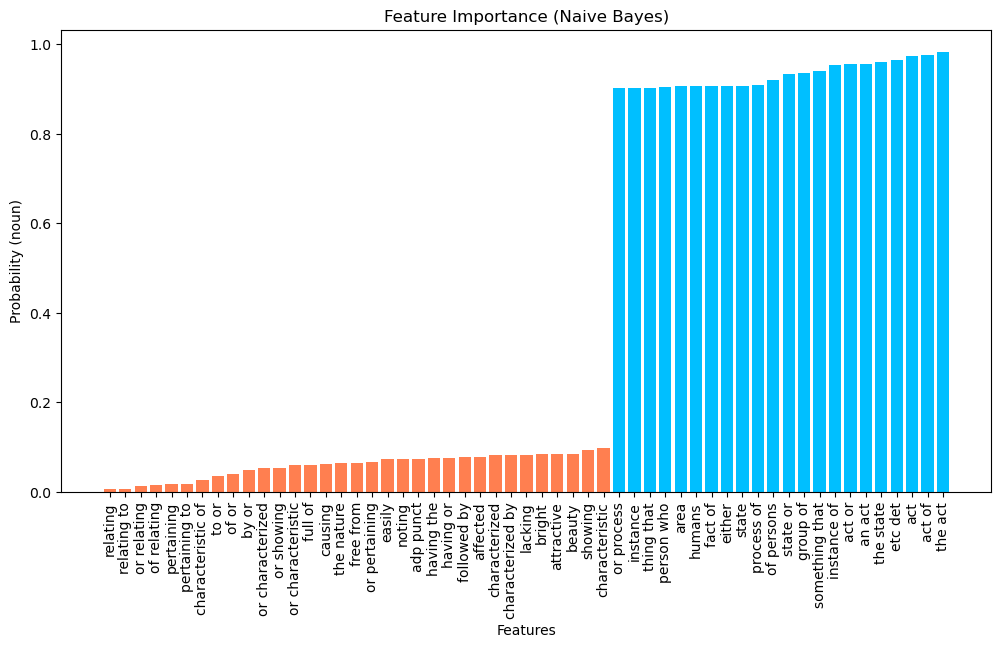

In [38]:
# Create a bar chart to show feature importance for the NB model.
# Uses probabilities.

nb_probs_bar = bar_eda(df=df_probs_nb_filtered, 
                       xaxis=df_probs_nb_filtered.word,
                       col='prob_noun', 
                       xlim=0.9, 
                       add_line=False, 
                       ylabel='Probability (noun)', 
                       title='Naive Bayes', 
                       rotation=90)

### Feature Importance

The chart above shows feature importance according to the NB model. As this is based on p(noun), the lower the value, the more indicative the feature is of adjectives, and vice-versa for nouns.

Some of these features are repetitive. As mentioned earlier, while NB's assumption of independence is not always correct, as these features really do appear almost exclusively in definitions of their respective word classes, it is less of an issue. 

For example, the word 'relating' had appeared _only_ within definitions of adjectives, and was never misclassified.

However, in the rare definitions that feature these words in an unexpected word class, some misclassifications may occur.

For example, the word 'act' appears in 266 definitions of nouns and 4 definitions of adjectives. Of these 4, 2 were misclassified as nouns.
- Correctly classified as adjective: 'true; not merely ostensible, nominal, or apparent: the real reason for an act.'
    - The model was able to correctly classify this definition largely due to the words 'real' and 'reason', both of which are words with fairly high p(adj).
- incorrectly classified as noun: 'existing in act or fact; real: an actual case of heroism; actual expenses.'
    - This misclassification by NB is not surprising - there is another word with a high p(noun) in it: 'fact'.

NB calculates probability rather simplistically, and as such often assigns high probabilities to features that have most of their occurrences tagged to the same class, and that are occur in a reasonable number of observations. As such, the features shown here are almost all actual words and phrases from definitions. This is not the case for LR, as we will see below.

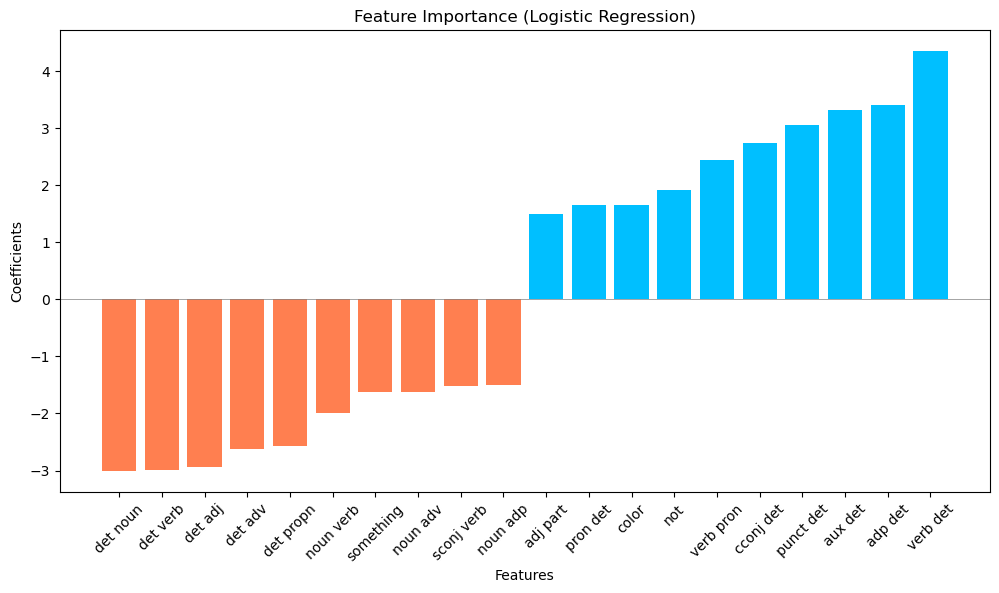

In [39]:
# Create a bar chart to show feature importance for the LR model.
# Uses coefficients.

lr_coefs_bar = bar_eda(df=df_lr_coefs_filtered, 
                       xaxis=df_lr_coefs_filtered.index, 
                       col='coefficient', xlim=0, 
                       add_line=True, 
                       ylabel='Coefficients', 
                       title='Logistic Regression', 
                       rotation=45)

### Feature Importance (cont'd)

The chart above shows feature importance according to the LR model. As this is based on the coefficients (log-odds), negative values are associated with nouns, and vice-versa for adjectives.

An example of how the coefficients can be interpreted using the feature 'det noun': for each unit increase in the feature within a definition, the log-odds of the definition being classified as an adjective decreases by 3.006.

Unlike the NB model, most of the features considered more significant by the LR model are parts-of-speech (POS). It is expected that this would not be the case for NB due to the general nature of POS - since they are essentially groupings of words, it is virtually impossible that an entire group is missing from a whole word class. Therefore, NB would not assign them as high probabilities. In fact, probabilties of features extracted from definitions would not change regardless of whether parts of speech are included in the model.

However, LR is more holistic. Since its equation has to balance all of the features, any 'movement' affects the coefficients across board. In this way, LR is able to learn from the inclusion of POS within the data. For example, consider the following phrases:
- 'the act of'
- 'the instance of'
- 'the state of'

All of them appear largely in definitions of nouns. Let's assume, for the sake of this example, that they rarely appear together. Without their relevant POS (determiner-noun-adposition), it would be difficult for the model the learn anything other than that they are very predictive of nouns. _With_ the inclusion of the POS, it will be a lot easier for the model to detect the underlying structure, because it would be able to detect that whenever each of these phrases appears in a definition, the same POS also appears. This way, it will be able to learn and model certain aspects of structure, and reflect these discoveries accordingly in the coefficients. This is likely why most of the key features for the LR model are actually POS.

---
## Applications, Limitations & Further Extensions
---

### Applications

#### Friendly competition

The primary use of this model would be to serve as a 'competitor' to learners, who could be students or otherwise non-native speakers. For any given definition, the learner would classify it as either a noun or an adjective, and compare their answer against the model's classification. 

Naturally, for this to work out, there must be a 'correct' answer. In the context of the data we've been dealing with, it would necessitate, for example, the `df_word['word_class']` column to output the answer. Thus, the model would output two things: the correct answer from the dataset, as well as its predictions. 


#### Contextual clues - key skill taught in schools

The picking out of contextual clues is a skill that is increasingly emphasised upon in recent years in schools. In the context of this project, it would look something like this: "Why did you classify this definition as a noun? Which part or parts of the definition led you to this conclusion?" The main point of this is to encourage students to engage in close-reading (yet another important skill emphasised upon) as well as enable them to be able to explain their thought process, therefore improving logical-thinking as well as communication skills.

These models, being easily interpretable, can essentially do the same thing through feature importance. For example, in Naive Bayes, it's as simple as look at the probabilities of each distinct part in the definition. In other words, not only can students test their accuracy against the model, they can also check to see if they were able to pick out the most important clues (assuming the model classified it correctly).


#### Infinitely customisable

Learners vary greatly in terms of language ability as well as personal characteristics. Some students may appreciate and welcome tough challenges while others may shy away when they keep 'losing' to the model. Being models, customising accuracy rate is very doable. Therefore, it is possible to offer every learner a different 'difficulty level' depending on their preferences or needs.

### Limitations

This project features a small-scale model built on approximately 4,000 definitions all from the same source. 

First of all, this makes it difficult to achieve extremely high accuracy rates that may be needed in some cases, especially if a potential selling point is customisability. 

Secondly, dictionary definitions are very precise, which makes some of them potentially rather difficult to understand, which may in turn be confusing for the learner or unfair to them.

To tackle the above, a 'next version' of this model should ideally be trained on a much larger set of data from varying sources such that it is much easier for the model to generalise. 

In addition, it may be necessary for to have, for example, a function that isn't related to the data at all. Instead, it merely tweaks the class labels on a random basis to offer the 'illusion' of a model. This would be the most straightforward and reliable way of ensuring that we can cater to learners who want a model with extremely high accuracy levels. Of course, this is merely a short-term solution, because it wouldn't be a model at all, rather just a simple function that is unable to learn from data or generalise to unseen data.

### Further Extensions

If we think of this model as a blueprint, there may be many additional use cases for future versions of it.

#### Classifying user-defined definitions

If the model has been trained on an extremely large and diverse dataset, it may be possible for it to accept user-defined definitions as well. This could be rather fun for users, and the 'contextual clues' function (feature importance) can help users to understand why, for example, their definitions are not classified into the word class they intended it to be.

#### Other POS

If the quantity and quality of the data can be improved upon, it follows that the model would be able to handle many other types of classification as well.

#### Beyond language

With a sufficient amount of data, it could become possible for the model to classify all manner of things. For example, for a given 'definition' or description, it may be possible for the model to classify landforms taught in Geography.

### Conclusion

This model, while just a small-scale NLP project, has shown us that it _is_ possible for us to use modelling to make learning and/or informal assessment more engaging. In addition, it has the benefit of harnessing technology and potentially being a good teaching resource for educators as well. With some tweaking, and the resources to improve it further, it could potentially become a power tool for the teaching and learning of not just language, but many other areas as well.